In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

* Lectura de datos

In [8]:
df = pd.read_csv('../datasets/student_lifestyle_dataset.csv')
df.head()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


* EDA:

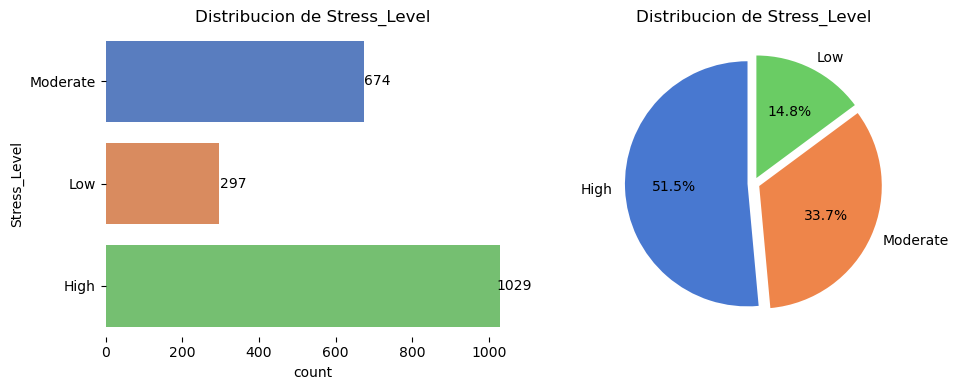

In [9]:
column_name = 'Stress_Level'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')  
plt.title(f'Distribucion de {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)


plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Distribucion de {column_name}')
plt.ylabel('')  

plt.tight_layout()
plt.show()

* La distribucion de la variable stress_level demuestra que el 51% de los estudiantes de la muestra demuestra estres alto, debido a su situacion academica, social, o estilo de vida
* Una minoria (18%) parece tener su vida bien balanceada 
* Se podria implicar que a mayor estres en un area, desencadena poco rendimiento en las otras (estres social provocaria que el rendimiento academico baje)

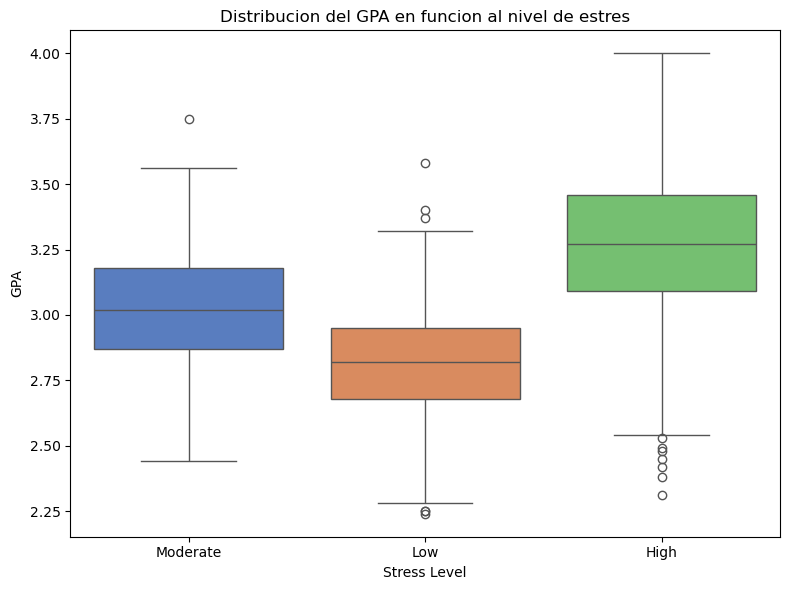

In [10]:

plt.figure(figsize=(8, 6))
sns.boxplot(x='Stress_Level', y='GPA', data=df, palette='muted')

plt.title('Distribucion del GPA en funcion al nivel de estres')
plt.xlabel('Stress Level')
plt.ylabel('GPA')

# Display the plot
plt.tight_layout()
plt.show()

* A mayor estres, mayor el nivel de GPA (medida estadounidense a calificaciones universitarias), aqui se observan valores atipicos en niveles de estres bajos, que podrian deberse a otros factores o ser outliers
* Se puede deducir entonces que uno de los factores de mayor estres para los estudiantes es justamente sus notas, por eso mientras mayor nivel de estres, mejor GPA

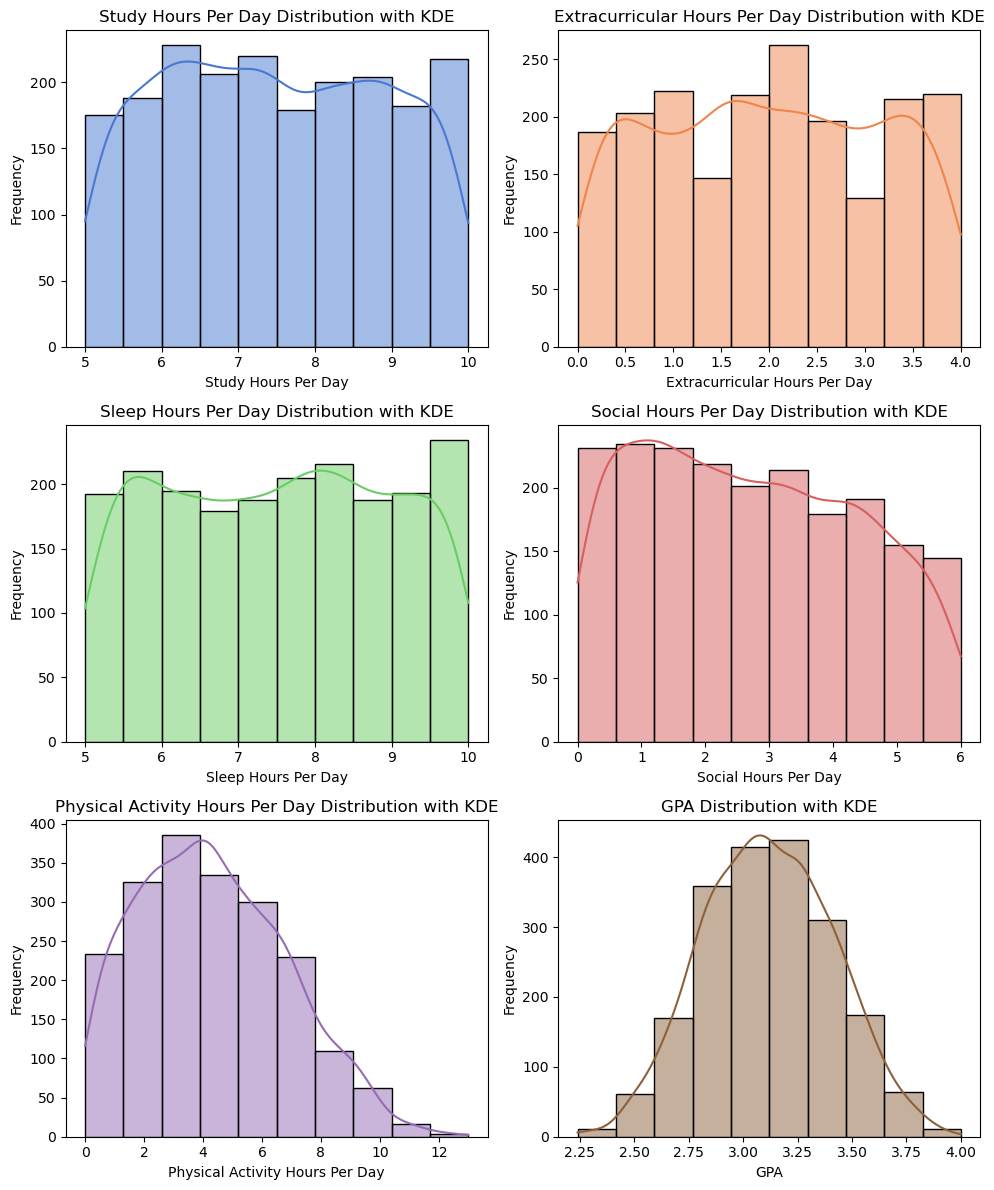

In [11]:
def univariate_analysis(data, columns):
    plt.figure(figsize=(10, 12))  
    
    muted_colors = sns.color_palette("muted", len(columns))
    
    for i, column in enumerate(columns):
        plt.subplot(3, 2, i + 1)  
        sns.histplot(data[column], kde=True, bins=10, color=muted_colors[i])
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 
                       'Physical_Activity_Hours_Per_Day', 'GPA']

univariate_analysis(df, columns_to_analyze)

* En el analisis univariado, podemos observar que:
 - los estudiantes tienden a practicar de 2 a 5 horas de actividad fisica
 - el GPA promedio es de 3.2 aproximadamente
 - la mayoria tiende a llegar a las 10 horas de suenho
 - la cantidad de horas dedicadas a la socializacion, parece decrecer siendo por dia entre 3 y 5 horas

* Matriz de correlacion

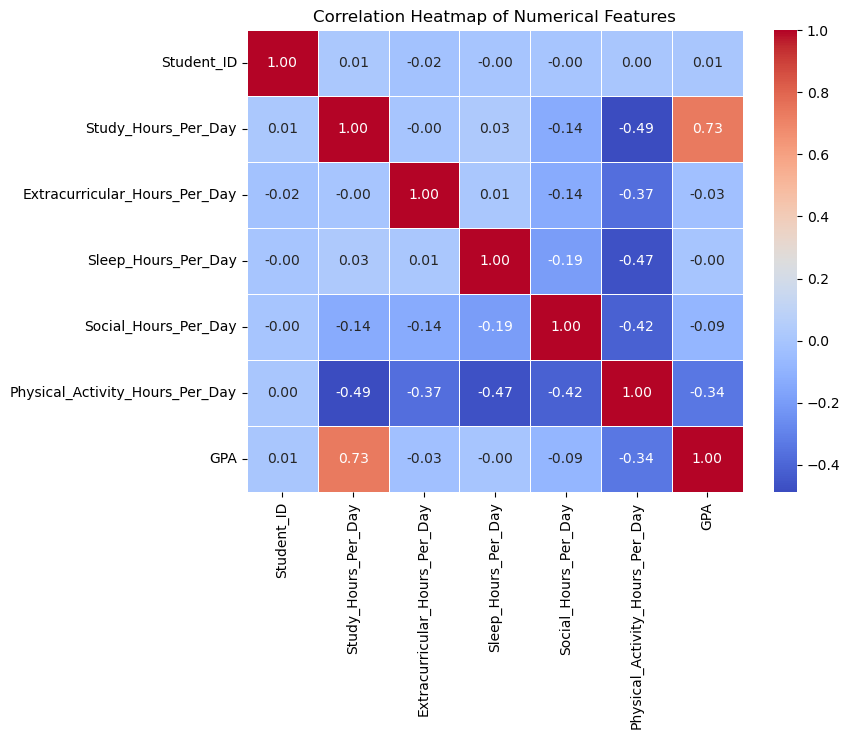

In [12]:
plt.figure(figsize=(8, 6))
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

* Correlacion fuerte entre cantidad de horas de estudios y GPA
* Correlacion moderada entre actividad fisica y GPA, lo que indica que mientras mas horas de ejercicio menos de estudio y menos GPA
* Correlacion despreciable entre actividades extracurriculares y GPA, indicando que las actividades de voluntariado no tienen impacto en el GPA 

* Caracteristicas y desafios
 - Es interesante analizar que tanto afecta el estres a la vida de los estudiantes, y a partir de este analisis, determinar si vale la pena un GPA mayor a cambio de un mayor estres